<a href="https://colab.research.google.com/github/nowshaba/Transferlearning/blob/main/Correct_AWID_mlp%2Csvm%2C_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import time
import sklearn.metrics as m
import keras
import tensorflow as tf
import sklearn
import tensorboard

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Avoid warnings
import warnings
warnings.filterwarnings('ignore')
#Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Import  Data
df=pd.read_csv("/content/drive/MyDrive/Datasets/AWIDnew/AWID.csv")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211189 entries, 0 to 211188
Data columns (total 84 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Unnamed: 0                          211189 non-null  int64  
 1   frame.interface_id                  211189 non-null  int64  
 2   frame.offset_shift                  211189 non-null  float64
 3   frame.time_epoch                    211189 non-null  float64
 4   frame.time_delta                    211189 non-null  float64
 5   frame.time_delta_displayed          211189 non-null  float64
 6   frame.time_relative                 211189 non-null  float64
 7   frame.len                           211189 non-null  int64  
 8   frame.cap_len                       211189 non-null  int64  
 9   frame.marked                        211189 non-null  int64  
 10  frame.ignored                       211189 non-null  int64  
 11  radiotap.version          

,Unnamed: 0,frame.interface_id,frame.offset_shift,frame.time_epoch,frame.time_delta,frame.time_delta_displayed,frame.time_relative,frame.len,frame.cap_len,frame.marked,frame.ignored,radiotap.version,radiotap.pad,radiotap.length,radiotap.present.tsft,radiotap.present.flags,radiotap.present.rate,radiotap.present.channel,radiotap.present.fhss,radiotap.present.dbm_antsignal,radiotap.present.dbm_antnoise,radiotap.present.lock_quality,radiotap.present.tx_attenuation,radiotap.present.db_tx_attenuation,radiotap.present.dbm_tx_power,radiotap.present.antenna,radiotap.present.db_antsignal,radiotap.present.db_antnoise,radiotap.present.rxflags,radiotap.present.xchannel,radiotap.present.mcs,radiotap.present.ampdu,radiotap.present.vht,radiotap.present.reserved,radiotap.present.rtap_ns,radiotap.present.vendor_ns,radiotap.present.ext,radiotap.mactime,radiotap.flags.cfp,radiotap.flags.preamble,radiotap.flags.wep,radiotap.flags.frag,radiotap.flags.fcs,radiotap.flags.datapad,radiotap.flags.badfcs,radiotap.flags.shortgi,radiotap.datarate,radiotap.channel.freq,radiotap.channel.type.turbo,radiotap.channel.type.cck,radiotap.channel.type.ofdm,radiotap.channel.type.2ghz,radiotap.channel.type.5ghz,radiotap.channel.type.passive,radiotap.channel.type.dynamic,radiotap.channel.type.gfsk,radiotap.channel.type.gsm,radiotap.channel.type.sturbo,radiotap.channel.type.half,radiotap.channel.type.quarter,radiotap.dbm_antsignal,radiotap.antenna,radiotap.rxflags.badplcp,wlan.fc.type_subtype,wlan.fc.version,wlan.fc.type,wlan.fc.subtype,wlan.fc.ds,wlan.fc.frag,wlan.fc.retry,wlan.fc.pwrmgt,wlan.fc.moredata,wlan.fc.protected,wlan.fc.order,wlan.duration,wlan.ra,wlan.da,wlan.ta,wlan.sa,wlan.bssid,wlan.frag,wlan.seq,wlan.fcs_good,class
0,26,0,0.0,1.393661e+09,0.012404,0.012404,0.345648,148,148,0,0,0,0,26,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0x00000000,0,0,0,2101944719,0,0,0,0,1,0,0,0,1.0,2437,0,1,0,1,0,0,0,0,0,0,0,0,-29,1,0,0x08,0,0,8,0x00,0,0,0,0,0,0,0,ff:ff:ff:ff:ff:ff,ff:ff:ff:ff:ff:ff,28:c6:8e:86:d3:d6,28:c6:8e:86:d3:d6,28:c6:8e:86:d3:d6,0,1045,1,normal
1,38,0,0.0,1.393661e+09,0.008836,0.008836,0.456882,75,75,0,0,0,0,26,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0x00000000,0,0,0,2102056536,0,0,0,0,1,0,0,0,1.0,2437,0,1,0,1,0,0,0,0,0,0,0,0,-23,1,0,0x04,0,0,4,0x00,0,0,0,0,0,0,0,ff:ff:ff:ff:ff:ff,ff:ff:ff:ff:ff:ff,00:1e:e5:9c:1d:1b,00:1e:e5:9c:1d:1b,ff:ff:ff:ff:ff:ff,0,955,1,normal
2,84,0,0.0,1.393661e+09,0.020195,0.020195,0.843532,185,185,0,0,0,0,26,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0x00000000,0,0,0,2102442296,0,0,0,0,1,0,0,0,1.0,2437,0,1,0,1,0,0,0,0,0,0,0,0,-61,1,0,0x08,0,0,8,0x00,0,0,0,0,0,0,0,ff:ff:ff:ff:ff:ff,ff:ff:ff:ff:ff:ff,38:22:9d:ae:c5:65,38:22:9d:ae:c5:65,38:22:9d:ae:c5:65,0,2171,1,normal
3,101,0,0.0,1.393661e+09,0.001847,0.001847,1.050226,185,185,0,0,0,0,26,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0x00000000,0,0,0,2102648985,0,0,0,0,1,0,0,0,1.0,2437,0,1,0,1,0,0,0,0,0,0,0,0,-62,1,0,0x08,0,0,8,0x00,0,0,0,0,0,0,0,ff:ff:ff:ff:ff:ff,ff:ff:ff:ff:ff:ff,38:22:9d:c4:8d:28,38:22:9d:c4:8d:28,38:22:9d:c4:8d:28,0,301,1,normal
4,112,0,0.0,1.393661e+09,0.000730,0.000730,1.165574,1524,1524,0,0,0,0,26,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0x00000000,0,0,0,2102765420,0,0,0,0,1,0,0,0,54.0,2437,0,0,1,1,0,0,0,0,0,0,0,0,-21,1,0,0x28,0,2,8,0x02,0,1,0,0,1,0,44,c0:18:85:94:b6:55,c0:18:85:94:b6:55,28:c6:8e:86:d3:d6,00:13:33:87:62:6d,28:c6:8e:86:d3:d6,0,103,1,normal


In [ ]:
drop_cols = []
for i in df.columns:
    if len(df[i].unique())==1:
        drop_cols.append(i)
print("Total columns with only 1 unique value:", len(drop_cols))
df.drop(drop_cols, 1, inplace=True)



Total columns with only 1 unique value: 53


In [ ]:
df.dropna(1,inplace=True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211189 entries, 0 to 211188
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  211189 non-null  int64  
 1   frame.time_epoch            211189 non-null  float64
 2   frame.time_delta            211189 non-null  float64
 3   frame.time_delta_displayed  211189 non-null  float64
 4   frame.time_relative         211189 non-null  float64
 5   frame.len                   211189 non-null  int64  
 6   frame.cap_len               211189 non-null  int64  
 7   radiotap.mactime            211189 non-null  int64  
 8   radiotap.datarate           211189 non-null  float64
 9   radiotap.channel.freq       211189 non-null  int64  
 10  radiotap.channel.type.cck   211189 non-null  int64  
 11  radiotap.channel.type.ofdm  211189 non-null  int64  
 12  radiotap.dbm_antsignal      211189 non-null  int64  
 13  wlan.fc.type_s

In [ ]:
#Split dataset on train and test
from sklearn.model_selection import train_test_split
train, test=train_test_split(df,test_size=0.3, random_state=10)

#Exploratory Analysis
# Descriptive statistics
train.describe()
test.describe()

# Packet Attack Distribution
train['class'].value_counts()
test['class'].value_counts()

normal           25954
injection        14061
flooding         11692
impersonation    11650
Name: class, dtype: int64

In [ ]:
#Scalling numerical attributes
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float32','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float32','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float32','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

In [ ]:
# importing one hot encoder from sklearn 
from sklearn.preprocessing import OneHotEncoder 

# creating one hot encoder object 
onehotencoder = OneHotEncoder() 

trainDep = train['class'].values.reshape(-1,1)
trainDep = onehotencoder.fit_transform(trainDep).toarray()
testDep = test['class'].values.reshape(-1,1)
testDep = onehotencoder.fit_transform(testDep).toarray()

In [ ]:
train_X=sc_traindf
train_y=trainDep[:,0]

test_X=sc_testdf
test_y=testDep[:,0]

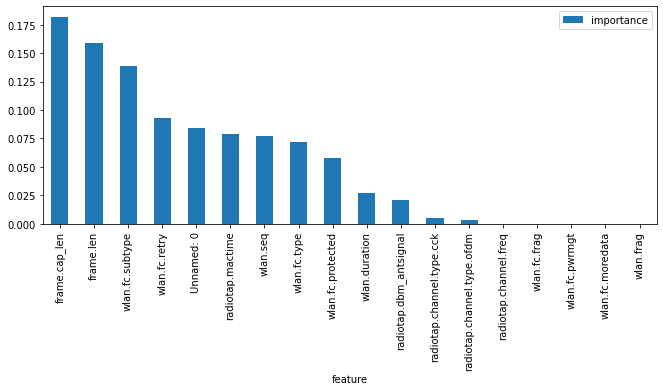

In [ ]:
#Feature Selection
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(train_X, train_y);

# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_X.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [ ]:
#Recursive feature elimination
from sklearn.feature_selection import RFE
import itertools

rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=20)
rfe = rfe.fit(train_X, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_X.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

a = [i[0] for i in feature_map]
train_X = train_X.iloc[:,a]
test_X = test_X.iloc[:,a]


In [ ]:
#Dataset Partition
X_train,X_test,Y_train,Y_test = train_test_split(train_X,train_y,train_size=0.70, random_state=2)

In [ ]:
 def model_values(lstm,lstmh,mlp,sup,X_test,Y_test):
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,classification_report,roc_curve
  print("********LSTM MODEL EVALUATION*********")
  print()
  print("Lstm accuracy is:", lstmh.history['accuracy'])
  print("Lstm loss is:", lstmh.history['loss'])

  y_pred = (lstm.predict(X_test).ravel()>0.5)+0 # predict and get class (0 if pred < 0.5 else 1)
  confusion_matrix = confusion_matrix(Y_test, y_pred)
  print("Confusion Matrix for LSTM model:", confusion_matrix)
  print()
  
  models = []
  models.append(('Multi layer perceptron',mlp))
  models.append(('Support vector machine Classifier',sup))

  for i,m in models:
    accuracy = sklearn.metrics.accuracy_score(Y_test, m.predict(X_test))
    confusion_matrix = sklearn.metrics.confusion_matrix(Y_test, m.predict(X_test))
    print()
    print('============================== {} Model Evaluation =============================='.format(i))
    print()
    print ("Model Accuracy :" "\n", accuracy)
    print()
    print("Confusion matrix :" "\n", confusion_matrix)
    print()

In [ ]:
#from sklearn.cluster import KMeans
#print('*** KMeans ***')

#X = df.iloc[:,[0:]].values
#Ds = pd.read_csv("/content/drive/MyDrive/Datasets/CIC_IDSCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
#X = train_X
#km = KMeans()
#km.fit(X);
def train_model(X_newtrain,Y_newtrain,X_test,Y_test):
  import sklearn.metrics 
  from sklearn.model_selection import cross_val_score
  from sklearn import svm
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
  import tensorflow as tf
  from tensorflow import keras
  from tensorflow.keras import layers
  from sklearn.neural_network import MLPClassifier
  from time import time
  print('*** MULTI LAYER PERCEPTRON ***')
  print()
  start1= time()
  mlp = MLPClassifier(warm_start=True,
  learning_rate='adaptive', early_stopping=True)

  mlp.fit(X_newtrain, Y_newtrain)
  print("Time taken to create and train MLP Model:", time()-start1, "secs")
  print()

  print('*** Support Vector Machine ***')
  print()
  #Create a svm Classifier
  start2=time()
  sup = svm.SVC(kernel='linear') # Linear Kernel

  #Train the model using the training sets
  sup.fit(X_newtrain, Y_newtrain)
  print("Time taken to create and train SVM :", time()-start2, "secs")
  print()

  print("********LSTM Model********")
  print()
#X_train = np.expand_dims(X_train, 1)
#X_train = X_train.reshape(len(X_train), 1, X_train.shape[1])
  start3=time()
  lstm = Sequential()
  lstm.add(layers.LSTM(200, input_shape=(18,1), return_sequences=True, activation='sigmoid'))
#lstm.add(Dropout(0.1))
#lstm.add(BatchNormalization())

  lstm.add(layers.LSTM(units=200,return_sequences=False, activation='sigmoid'))
#lstm.add(Dropout(0.1))
#lstm.add(BatchNormalization())

  lstm.add(layers.Dense(activation='sigmoid', units=1))
#model.add(Dropout(0.1))

  #print('Compiling...')
  #print()
#adam=tf.keras.optimizers.Adam(lr='adaptive')
  lstm.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
  #lstm.summary()
  lstmh = lstm.fit(X_newtrain, Y_newtrain)
#print(" Predicting ".center(termwidth,fillchar))
  print("Time taken to create and train LSTM Model:", time()-start3, "secs")
  print()
  model_values(lstm,lstmh,mlp,sup,X_test,Y_test)


In [ ]:
#Dividing the training data into smaller parts for results
size = 0.10
while(size<1.0):
   X_newtrain,X_ntest,Y_newtrain,Y_ntest = train_test_split(X_train,Y_train, train_size= size, random_state=2)
   print("***********MODEL PERFORMANCE EVALUATION ON", int(size*100) ,"% TRAINING DATA")
   train_model(X_newtrain,Y_newtrain,X_test,Y_test)
   size = (size+0.10)
else:
   if(size==1.0):
      print("***********MODEL PERFORMANCE EVALUATION ON", int(size*100) ,"% TRAINING DATA")
      train_model(X_train,Y_train,X_test,Y_test)


***********MODEL PERFORMANCE EVALUATION ON 10 % TRAINING DATA
*** MULTI LAYER PERCEPTRON ***

Time taken to create and train MLP Model: 4.874420404434204 secs

*** Support Vector Machine ***

Time taken to create and train SVM : 0.6010403633117676 secs

********LSTM Model********

324/324 [==============================] - 26s 66ms/step - loss: 0.4833 - accuracy: 0.8153
Time taken to create and train LSTM Model: 31.179828882217407 secs

********LSTM MODEL EVALUATION*********

Lstm accuracy is: [0.8153266310691833]
Lstm loss is: [0.4832519590854645]
Confusion Matrix for LSTM model: [[36216     0]
 [ 8134     0]]


============================== Multi layer perceptron Model Evaluation ==============================

Model Accuracy :
 0.9967756482525366

Confusion matrix :
 [[36096   120]
 [   23  8111]]


============================== Support vector machine Classifier Model Evaluation ==============================

Model Accuracy :
 0.9567756482525367

Confusion matrix :
 [[34723  1493